# Amazon's Alexa Product Reviews with NLP - A detailed guide

NLP, or natural language processing is a field concerned with the ability to understand, analyze, manipulate and potentially generate human language. 

In the following lines, it will be presented the analysis of Amazon Alexa product reviews using natural language processing techniques. 

Examples of the application of NLP in real life are:
- Auto completing on a google search, for example
- Auto correcting, when our phones instantly correct what we type 
- Spam filters in our e-mails



## 1 - Importing the Libraries

In [1]:
import numpy as np 
import pandas as pd 
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.preprocessing import OneHotEncoder
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

/kaggle/input/amazon-alexa-reviews/amazon_alexa.tsv


## 2 - Loading the File and simple EDA

In [2]:
reviews = pd.read_csv('../input/amazon-alexa-reviews/amazon_alexa.tsv', sep = '\t')
reviews.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1


Getting to know the dataset and the data characteristics:

In [3]:
reviews.shape

(3150, 5)

In [4]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   rating            3150 non-null   int64 
 1   date              3150 non-null   object
 2   variation         3150 non-null   object
 3   verified_reviews  3150 non-null   object
 4   feedback          3150 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 123.2+ KB


In [5]:
reviews['feedback'].unique()

array([1, 0])

In [6]:
print("We have a total of {} reviews".format(reviews.shape[0]))
print("Feedback = 1 means a positive review and Feedback=0 means a negative review")

We have a total of 3150 reviews
Feedback = 1 means a positive review and Feedback=0 means a negative review


 Checking the statistics about the data:

In [7]:
reviews.describe()

,rating,feedback
count,3150.000000,3150.000000
mean,4.463175,0.918413
std,1.068506,0.273778
min,1.000000,0.000000
25%,4.000000,1.000000
50%,5.000000,1.000000
75%,5.000000,1.000000
max,5.000000,1.000000


Checking the feedback classification:

In [8]:
reviews['feedback'].unique()

array([1, 0])

Separating the positive and negative reviews into different dataframes:

In [9]:
positive = reviews[reviews['feedback'] == 1]
p = len(positive)
negative = reviews[reviews['feedback'] == 0]
n = len(negative)
print('The number of positive reviews is {} and negative reviews is {}'.format(p,n))

rat1 = len(reviews[reviews['rating']==1])
rat2 = len(reviews[reviews['rating']==2])
rat3 = len(reviews[reviews['rating']==3])
rat4 = len(reviews[reviews['rating']==4])
rat5 = len(reviews[reviews['rating']==5])
print('{} ratings = 1'.format(rat1))
print('{} ratings = 2'.format(rat2))
print('{} ratings = 3'.format(rat3))
print('{} ratings = 4'.format(rat4))
print('{} ratings = 5'.format(rat5))

The number of positive reviews is 2893 and negative reviews is 257
161 ratings = 1
96 ratings = 2
152 ratings = 3
455 ratings = 4
2286 ratings = 5


In [10]:
negative.describe()

,rating,feedback
count,257.000000,257.0
mean,1.373541,0.0
std,0.484688,0.0
min,1.000000,0.0
25%,1.000000,0.0
50%,1.000000,0.0
75%,2.000000,0.0
max,2.000000,0.0


In [11]:
positive.describe()

,rating,feedback
count,2893.000000,2893.0
mean,4.737643,1.0
std,0.546544,0.0
min,3.000000,1.0
25%,5.000000,1.0
50%,5.000000,1.0
75%,5.000000,1.0
max,5.000000,1.0


A graphical visualization for the information above: 

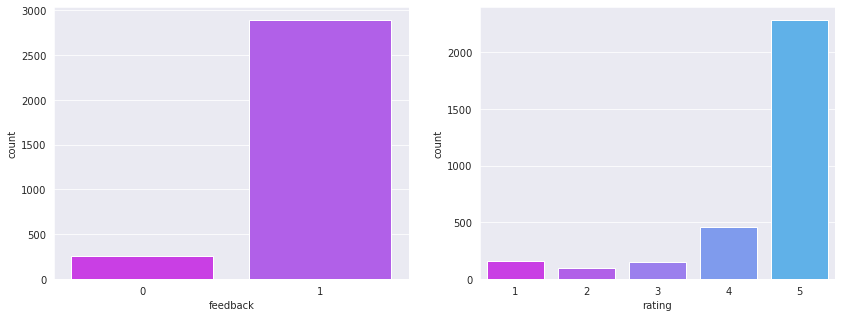

In [12]:
fig_dims= (14,5)
sns.set_palette("cool_r")
sns.set_style("darkgrid") 
fig, ax = plt.subplots(1,2, figsize=fig_dims)
sns.countplot(reviews['feedback'], ax=ax[0])
sns.countplot(reviews['rating'], ax=ax[1])
fig.show()


The initial analysis shows us that: 
- Ratings go from 1 to 5
- Ratings from 3 to 5 are classified as positive reviews and from 1 to 2 as negative reviews
- We can see from this evaluation that Amazon Alexa has very good reviews in general, being classified as positive 91,8% (2893 reviews).
- There is a prevalence of ratings equal to 5 in the reviews. 
- The feedback is classified as 1 for good reviews and 0 for bad reviews.

## 3- Analysing the text from the reviews

#### How many characters each review has?
The more the characters more words we will have for our sentiment analysis. Longer reviews are, in general, more accurate as the customer explains in detail the rating he is giving. It is therefore important to check how long the reviews are in our dataset. 

In [13]:
reviews['length'] = reviews['verified_reviews'].apply(len)
reviews.head()

,rating,date,variation,verified_reviews,feedback,length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1,195
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1,172
4,5,31-Jul-18,Charcoal Fabric,Music,1,5


Plotting the frequency distribution of the length of the reviews:

Text(0, 0.5, 'Frequency')

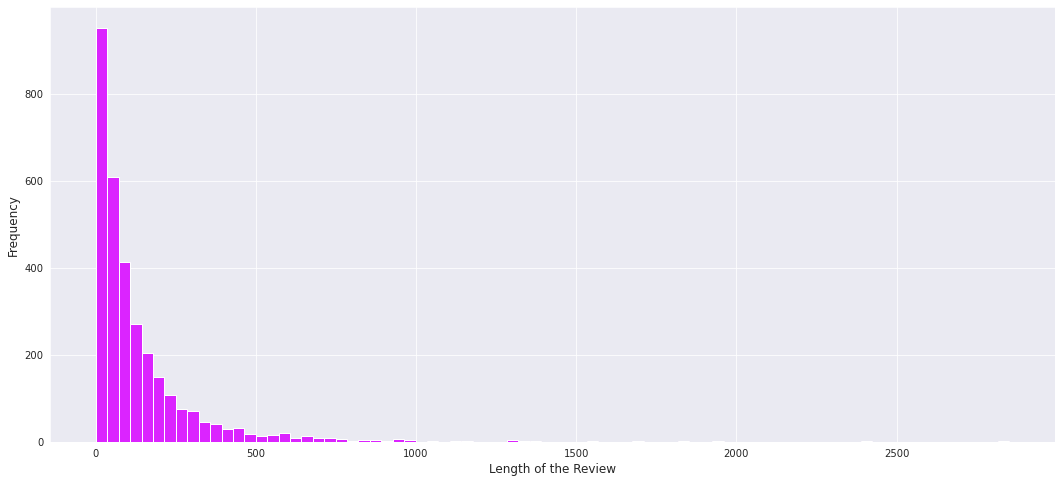

In [14]:
sns.set_palette("cool_r")
sns.set_style("darkgrid") 
reviews['length'].plot(bins = 80, kind = 'hist', figsize=(18,8))
plt.xlabel("Length of the Review", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

In [15]:
reviews.length.describe()

count    3150.000000
mean      132.049524
std       182.099952
min         1.000000
25%        30.000000
50%        74.000000
75%       165.000000
max      2851.000000
Name: length, dtype: float64

Let's see again the statistics for the positive and negative reviews, now with the information of length:

In [16]:
reviews[reviews["feedback"]==1].describe()

,rating,feedback,length
count,2893.000000,2893.0,2893.000000
mean,4.737643,1.0,124.659177
std,0.546544,0.0,174.624491
min,3.000000,1.0,1.000000
25%,5.000000,1.0,29.000000
50%,5.000000,1.0,69.000000
75%,5.000000,1.0,154.000000
max,5.000000,1.0,2851.000000


In [17]:
reviews[reviews["feedback"]==0].describe()

,rating,feedback,length
count,257.000000,257.0,257.000000
mean,1.373541,0.0,215.241245
std,0.484688,0.0,236.325955
min,1.000000,0.0,1.000000
25%,1.000000,0.0,53.000000
50%,1.000000,0.0,137.000000
75%,2.000000,0.0,289.000000
max,2.000000,0.0,1686.000000


We can conclude from the information above that: 
- Most of the reviews have around 300 characters 
- The shortest review has 1 character and the longest review has 2851 characters
- On average, reviews are 132 characters long. 
- The length of the review differs, on average, if the review is positive or negative. Positive reviews are, on average, 124 characters long and negative reviews are, on average, 215 characters long. 
- A quick superficial conclusion from that is that people who are unhappy with the product tend to write more on the review. 


Let's visualize the shortest and the longest reviews:

In [18]:
#Shortest review:
reviews[reviews ['length']==1]['verified_reviews'].iloc[0]

'😍'

In [19]:
#Longest review:
reviews[reviews ['length']==2851]['verified_reviews'].iloc[0]

"Incredible piece of technology.I have this right center of my living room on an island kitchen counter. The mic and speaker goes in every direction and the quality of the sound is quite good. I connected the Echo via Bluetooth to my Sony soundbar on my TV but find the Echo placement and 360 sound more appealing. It's no audiophile equipment but there is good range and decent bass. The sound is more than adequate for any indoor entertaining and loud enough to bother neighbors in my building. The knob on the top works great for adjusting volume. This is my first Echo device and I would imagine having to press volume buttons (on the Echo 2) a large inconvenience and not as precise. For that alone I would recommend this over the regular Echo (2nd generation).The piece looks quality and is quite sturdy with some weight on it. The rubber material on the bottom has a good grip on the granite counter-- my cat can even rub her scent on it without tipping it over.This order came with a free Phi

The reviews are not about the exact same product. There are some variations and these variations are described in the 'variation' column of the dataframe. The plot below shows 

In [20]:
reviews.variation.unique()

array(['Charcoal Fabric ', 'Walnut Finish ', 'Heather Gray Fabric ',
       'Sandstone Fabric ', 'Oak Finish ', 'Black', 'White',
       'Black  Spot', 'White  Spot', 'Black  Show', 'White  Show',
       'Black  Plus', 'White  Plus', 'Configuration: Fire TV Stick',
       'Black  Dot', 'White  Dot'], dtype=object)

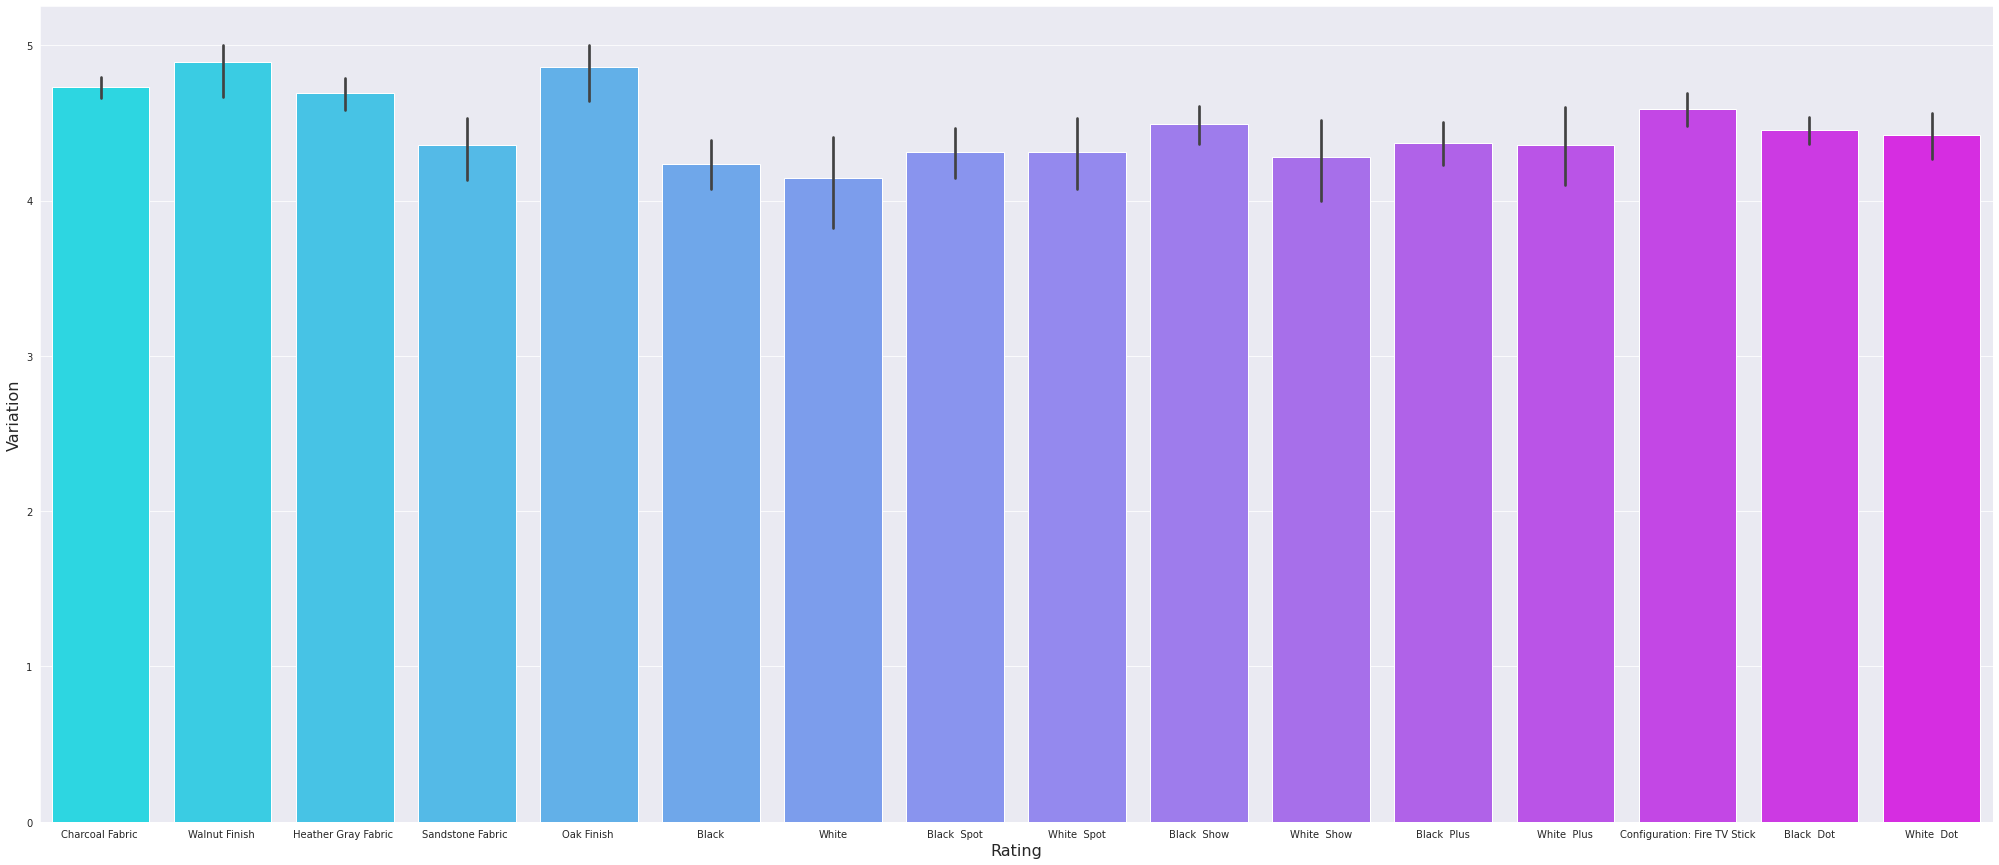

In [21]:
plt.figure(figsize = (35,15))
sns.set_style("darkgrid") 
#reviews_df = reviews.sort_values(['rating'])
sns.barplot(x = 'variation', y = 'rating', data = reviews, palette = 'cool')
plt.xlabel("Rating", fontsize=16)
plt.ylabel("Variation", fontsize=16);


The product variations does not seem to influence the ratings, as none of the categories fall below rating 4. 

## 4- Transforming the data and cleaning

Starting to prepare the data to create the wordcloud

In [22]:
sentences = reviews['verified_reviews'].tolist()
len(sentences)

3150

Now joining all reviews into one object , each review separated by a space.

In [23]:
sentences_str = ' '.join(sentences)
sentences_str

'Love my Echo! Loved it! Sometimes while playing a game, you can answer a question correctly but Alexa says you got it wrong and answers the same as you.  I like being able to turn lights on and off while away from home. I have had a lot of fun with this thing. My 4 yr old learns about dinosaurs, i control the lights and play games like categories. Has nice sound when playing music as well. Music I received the echo as a gift. I needed another Bluetooth or something to play music easily accessible, and found this smart speaker. Can’t wait to see what else it can do. Without having a cellphone, I cannot use many of her features. I have an iPad but do not see that of any use.  It IS a great alarm.  If u r almost deaf, you can hear her alarm in the bedroom from out in the living room, so that is reason enough to keep her.It is fun to ask random questions to hear her response.  She does not seem to be very smartbon politics yet. I think this is the 5th one I\'ve purchased. I\'m working on 

In [24]:
len(sentences_str)

419105

So we have an object with 419105 characters. For now on the work will focus on cleaning this data to keep only the elements necessary for the sentiment analysis of the reviews.

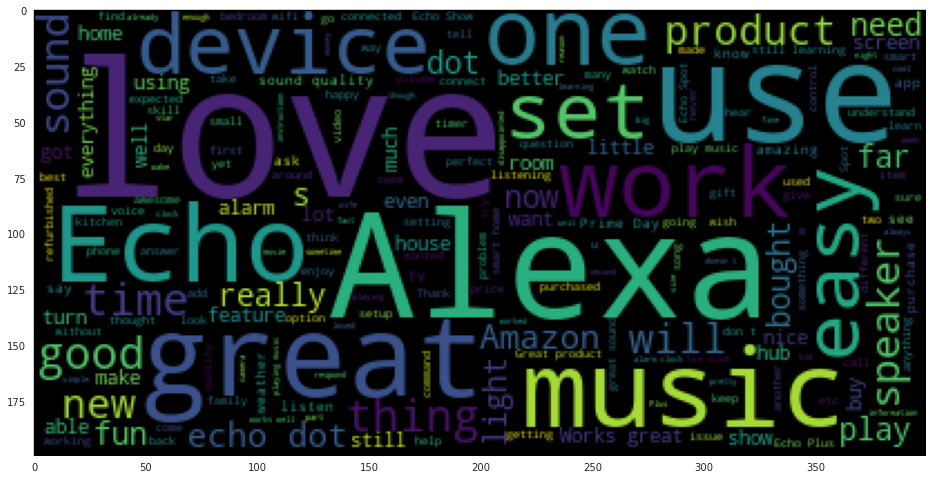

In [25]:
plt.figure(figsize=(16,14))
plt.grid(b=None)
plt.imshow(WordCloud().generate(sentences_str));

By having a quick look on the wordcloud we can see that words coming from positive reviews are more prevalent. To visualize most common words for each type of review, let's separate the wordcloud for positive reviews and negative reviews. 

### Wordcloud for the positive reviews:

In [26]:
positive_list = positive['verified_reviews'].tolist()
positive_str = ' '.join(positive_list)
len(positive_str)

363531

There are 363531 characters in the positive reviews list. 

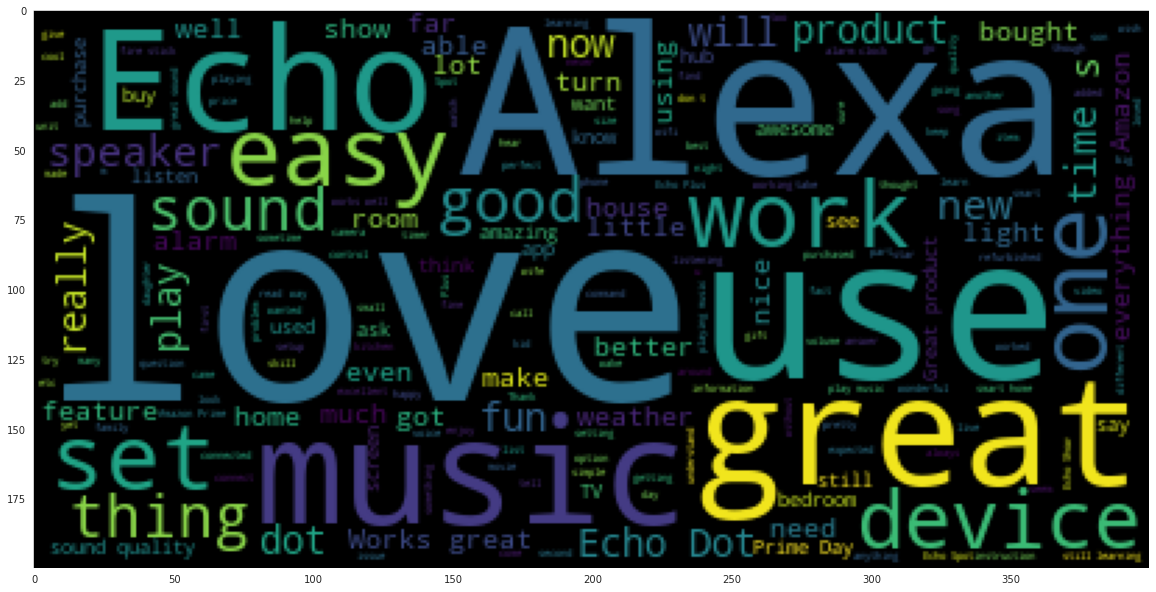

In [27]:
plt.figure(figsize=(20,20))
plt.grid(b=None)
plt.imshow(WordCloud().generate(positive_str));

### Wordcloud only for the negative reviews:

In [28]:
negative_list = negative['verified_reviews'].tolist()
negative_str = ' '.join(negative_list)
len(negative_str)

55573

There are 55573 characters in the negative reviews list. 

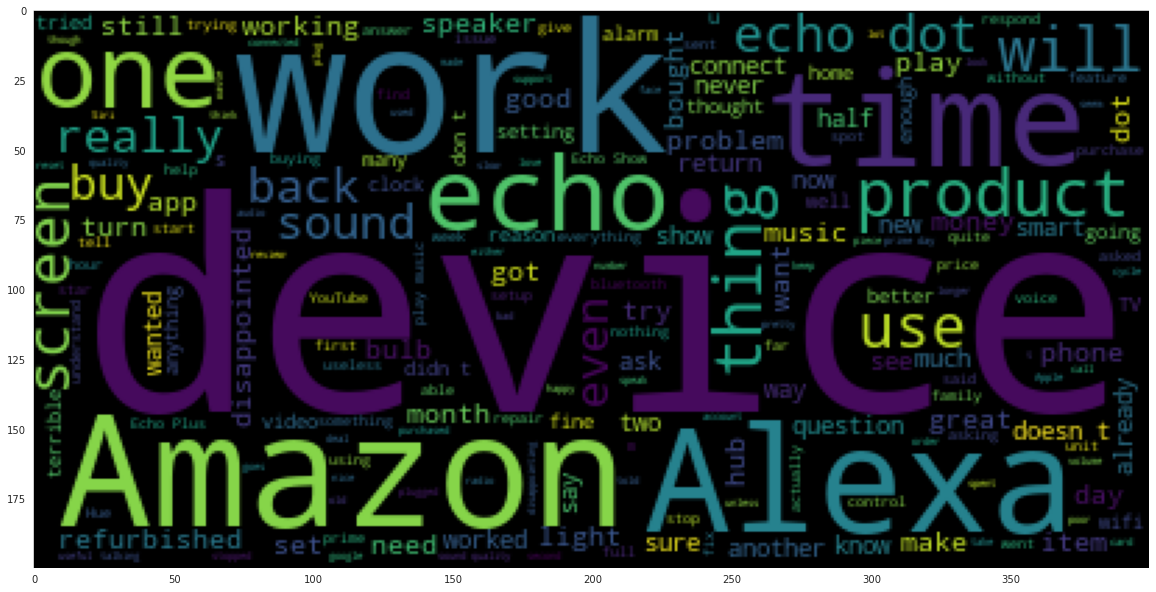

In [29]:
plt.figure(figsize=(20,20))
plt.grid(b=None)
plt.imshow(WordCloud().generate(negative_str));

There are too many unecessary words we need to clear from the wordclouds, such as 'one', 'use', 'dot'...

### Cleaning the data

The analysis will focus on the content of the reviews, so, from now on some information are not necessary: length, date and rating. 

In [30]:
reviews.head()

,rating,date,variation,verified_reviews,feedback,length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1,195
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1,172
4,5,31-Jul-18,Charcoal Fabric,Music,1,5


In [31]:
reviews = reviews.drop(['date', 'rating', 'length'], axis = 1)
reviews.head()

,variation,verified_reviews,feedback
0,Charcoal Fabric,Love my Echo!,1
1,Charcoal Fabric,Loved it!,1
2,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,Charcoal Fabric,Music,1


Visualizing the unique cathegories for the 'variation' column:

In [32]:
reviews['variation'].unique()

array(['Charcoal Fabric ', 'Walnut Finish ', 'Heather Gray Fabric ',
       'Sandstone Fabric ', 'Oak Finish ', 'Black', 'White',
       'Black  Spot', 'White  Spot', 'Black  Show', 'White  Show',
       'Black  Plus', 'White  Plus', 'Configuration: Fire TV Stick',
       'Black  Dot', 'White  Dot'], dtype=object)

### Transforming categorical values into numerical
Many machine learning algorithms cannot work with categorical data directly, so it is a common practice to transform categorical data into numerical to prepare the model for training. 

One hot encoder is a way of creating categories when a simple 0 for negative and 1 for positive is not possible or easy to implement. 

In [33]:
X_cat = reviews[['variation']]
onehotencoder = OneHotEncoder()
X_cat = onehotencoder.fit_transform(X_cat).toarray()

In [34]:
 X_cat.shape

(3150, 16)

In [35]:
#Confirming that X_cat is a numpy array
type(X_cat)

numpy.ndarray

X_cat must be transformed into a pandas dataframe so that it can be joined with the other information:

In [36]:
X_cat = pd.DataFrame(X_cat)
X_cat.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Now that we transformed the variation data from cathegorical to numerical, this column can be deleted from the original dataframe:

In [37]:
reviews.drop(['variation'], axis = 1, inplace = True)
reviews.head()

,verified_reviews,feedback
0,Love my Echo!,1
1,Loved it!,1
2,"Sometimes while playing a game, you can answer...",1
3,I have had a lot of fun with this thing. My 4 ...,1
4,Music,1


Joining the original dataframe with the transformed data:

In [38]:
reviews = pd.concat([reviews, X_cat], axis = 1)
reviews

,verified_reviews,feedback,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,Love my Echo!,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Loved it!,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"Sometimes while playing a game, you can answer...",1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,I have had a lot of fun with this thing. My 4 ...,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Music,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3145,"Perfect for kids, adults and everyone in betwe...",1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3146,"Listening to music, searching locations, check...",1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3147,"I do love these things, i have them running my...",1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3148,Only complaint I have is that the sound qualit...,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


### Removing punctuation 

Below the strings which are classified as punctuation. They will be removed from the data as they are unecessary for the analysis. 

In [39]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

Just testing with a sentence taken from the reviews:

In [40]:
test = 'Sometimes while playing a game, you can answer'
test_punc_removed = [char for char in test if char not in string.punctuation]
print(test_punc_removed)

['S', 'o', 'm', 'e', 't', 'i', 'm', 'e', 's', ' ', 'w', 'h', 'i', 'l', 'e', ' ', 'p', 'l', 'a', 'y', 'i', 'n', 'g', ' ', 'a', ' ', 'g', 'a', 'm', 'e', ' ', 'y', 'o', 'u', ' ', 'c', 'a', 'n', ' ', 'a', 'n', 's', 'w', 'e', 'r']


We can see that the comma after the word 'game'  was removed. It is shown by a blank space ' '. 

### NLTK to remove stopwords
NLTK stands for Natural Language Toolkit, which contain many tools to build NLP processes. 

In [41]:
#Downloading stopwords 
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Which are the stop words in English?

In [42]:
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

### Tokenizing

Tokenization means breaking down text content into its parts:
- Words
- Terms
- Symbols
Or other types of textual elements. 

This process of breaking down the content into smaller parts makes it easy the process of cleaning the data. 

### Applying the functions described to clean the data

In [43]:
def cleaning(message):
  text = [char for char in message if char not in string.punctuation]
  text = ''.join(text)
  text = [word for word in text.split() if word.lower() not in stopwords.words('english')]
  return text

In [44]:
reviews_clean = reviews['verified_reviews'].apply(cleaning)

Checking if the cleaning process went well by printing a random register in the data:

In [45]:
print(reviews_clean[100])

['Great', 'fun', 'getting', 'know', 'functions', 'product', 'WOW', 'family', 'fun', 'homework', 'help', 'Talking', 'grandchildrenwho', 'also', 'Echo', 'HUGE', 'bonus', 'Cant', 'wait', 'learn']


In [46]:
print(reviews['verified_reviews'][100])

Great fun getting to know all the functions of this product.  WOW -- family fun and homework help.  Talking with other grandchildren,who also have an Echo, is a HUGE bonus.  Can't wait to learn more and more and more


We can confirm that the stopwords and punctuation were removed. 

Transforming the text information into a vector with count vectorizer:

In [47]:
reviews_clean

0                                            [Love, Echo]
1                                                 [Loved]
2       [Sometimes, playing, game, answer, question, c...
3       [lot, fun, thing, 4, yr, old, learns, dinosaur...
4                                                 [Music]
                              ...                        
3145                    [Perfect, kids, adults, everyone]
3146    [Listening, music, searching, locations, check...
3147    [love, things, running, entire, home, TV, ligh...
3148    [complaint, sound, quality, isnt, great, mostl...
3149                                               [Good]
Name: verified_reviews, Length: 3150, dtype: object

In [48]:
vectorizer = CountVectorizer(analyzer=cleaning)

Processing the database on the vectorizer:

In [49]:
reviews_countvectorizer = vectorizer.fit_transform(reviews['verified_reviews'])

Visualizing the unique words extracted by the vectorizer:

In [50]:
print(vectorizer.get_feature_names())

['072318', '1', '10', '100', '1000', '100X', '1010', '1030pm', '11', '1100sf', '1220', '129', '12am', '15', '150', '19', '1964', '1990s', '1990’s', '1GB', '1rst', '1st', '2', '20', '200', '2000', '2017', '2030', '229', '23', '2448', '247', '24GHZ', '24ghz', '25', '29', '299', '2999', '2Original', '2nd', '2or', '2package', '3', '30', '300', '30so', '334', '34', '342nd', '3434', '34A34', '34Alexa', '34Alexa34', '34Certified', '34Computer34', '34Dot34', '34Drop', '34First', '34Hub', '34I', '34Im', '34NEVER', '34Philips', '34Play', '34Second', '34Skills34', '34Tell', '34The', '34Things', '34Thongs', '34Try', '34Whats', '34alexa34', '34card34', '34cycle', '34cycle34', '34fixes34', '34fun34', '34group34', '34hear34', '34hmm', '34hmmm', '34it34', '34late', '34learn', '34light34', '34lights34', '34listen34', '34minor', '34outlet34', '34personal34', '34she34', '34show', '34smart', '34smart34', '34sorry', '34spying34', '34the', '34thick34', '34things', '34this', '34trouble', '34try', '34turn', '

In [51]:
len(vectorizer.get_feature_names())

5211

In [52]:
reviews_countvectorizer.shape

(3150, 5211)

In [53]:
reviews

,verified_reviews,feedback,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,Love my Echo!,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Loved it!,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"Sometimes while playing a game, you can answer...",1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,I have had a lot of fun with this thing. My 4 ...,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Music,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3145,"Perfect for kids, adults and everyone in betwe...",1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3146,"Listening to music, searching locations, check...",1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3147,"I do love these things, i have them running my...",1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3148,Only complaint I have is that the sound qualit...,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


Now we can delete the verified reviews column from the original dataframe because it was already processed:

In [54]:
reviews.drop(['verified_reviews'], axis = 1, inplace=True)

In [55]:
reviews

,feedback,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3145,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3146,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3147,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3148,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


Creating a dataframe with the data from the vectorizer:

In [56]:
reviews2 = pd.DataFrame(reviews_countvectorizer.toarray())
reviews2

,0,1,2,3,4,5,6,7,8,9,...,5201,5202,5203,5204,5205,5206,5207,5208,5209,5210
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3145,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3146,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3147,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3148,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [57]:
X = reviews2
X

,0,1,2,3,4,5,6,7,8,9,...,5201,5202,5203,5204,5205,5206,5207,5208,5209,5210
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3145,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3146,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3147,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3148,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [58]:
y = reviews['feedback']
y

0       1
1       1
2       1
3       1
4       1
       ..
3145    1
3146    1
3147    1
3148    1
3149    1
Name: feedback, Length: 3150, dtype: int64

## 5- Training and Evaluating the Model with Logistic Regression

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [60]:
X_train.shape, X_test.shape

((2520, 5211), (630, 5211))

In [61]:
logistic = LogisticRegression()
logistic.fit(X_train, y_train)

LogisticRegression()

In [62]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [63]:
y_pred = logistic.predict(X_test)

In [64]:
accuracy_score(y_test, y_pred)

0.9317460317460318

In [65]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.34      0.46        53
           1       0.94      0.99      0.96       577

    accuracy                           0.93       630
   macro avg       0.82      0.66      0.71       630
weighted avg       0.92      0.93      0.92       630



The model is having difficulty in identifying the negative reviews - we can see that from the recall result for class 0: only 35% of the registers are correctly estimated. 
We must remember that we are dealing with a very unbalanced dataset - most of the reviews are positive reviews. ]

Further analysis is necessary to improve the analysis and adapt the model to deal with unbalanced data. Some options are listed below:
- 